In [1]:
from generate_configurations import read_configurations
import numpy as np
import matplotlib.pyplot as plt
from corr_funcs import *
from ising import corr_analytical
from scipy.stats import sem

In [2]:
sizes = [100, 1000]
betas = [0.5, 1, 2]
corr_functions = [corr_1, corr_2, corr_3, corr_4, corr_5, corr_6]
nrows = len(betas)
ncols = len(sizes)

In [3]:
loaded_data = {}
for size in sizes:
    for beta in betas:
        file_name = f'data/{size}_{beta}.npz'
        configurations, _, _, params = read_configurations(file_name)
        loaded_data[(size, beta)] = (configurations, params)

In [4]:
equations = {
    'corr_1': r'$\hat{C}_1(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} \right)$',
    'corr_2': r'$\hat{C}_2(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} - \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right) \left( \frac{1}{R} \sum_{k=1}^{R} \sigma_{i+r} \right) \right)$',
    'corr_3': r'$\hat{C}_3(r) = \frac{\hat{C}_2(r)}{\hat{C}_2(0)}$',
    'corr_4': r'$\hat{C}_4(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} - \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right)^2 \right) \left( 1 - \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right)^2 \right)$',
    'corr_5': r'$\hat{C}_5(r) = \frac{1}{R} \sum_{k=1}^{R} \left( \frac{1}{L} \sum_{i=1}^{L} \sigma_i \sigma_{i+r} - \left( \frac{1}{R} \sum_{k=1}^{R} \frac{1}{L} \sum_{i=1}^{L} \sigma_i \right)^2 \right)$',
    'corr_6': r'$\hat{C}_6(r) = \frac{\hat{C}_5(r)}{\hat{C}_5(0)}$',
}

In [5]:
corrs = []
for k, corr_function in enumerate(corr_functions):
    cr_sizes = []
    for i, size in enumerate(sizes):
        rs = np.concatenate((np.arange(0, 10, 1), np.arange(10, size - 10, 10), np.arange(size - 10, size + 1, 1)))
        cr_betas = []
        for j, beta in enumerate(betas):
            file_name = f'data/{size}_{beta}.npz'
            configurations, params = loaded_data[(size, beta)]
            corrs_an = np.array([corr_analytical(params['beta'], params['J'], params['size'], r) for r in rs])
            cr = corr_function_parallel(configurations, rs, corr_function)
            cr_betas.append(cr)
        cr_sizes.append(cr_betas)
    corrs.append(cr_sizes)


/Users/shivomgupta/Documents/Thesis/corr_funcs.py:45: RuntimeWarning: invalid value encountered in divide
  return np.sum((sum_prod - sum_sq)/(1-sum_sq)) / R


In [6]:
corrs_an = []
for i, size in enumerate(sizes):
    rs = np.concatenate((np.arange(0, 10, 1), np.arange(10, size - 10, 10), np.arange(size - 10, size + 1, 1)))
    cr_an_betas = []
    for j, beta in enumerate(betas):
        file_name = f'data/{size}_{beta}.npz'
        configurations, params = loaded_data[(size, beta)]
        cr = np.array([corr_analytical(params['beta'], params['J'], params['size'], r) for r in rs])
        cr_an_betas.append(cr)
    corrs_an.append(cr_an_betas)

In [7]:
errors = []
for i in range(len(sizes)):
    err_beta = []
    for j in range(len(betas)):
        cr = [corrs[k][i][j] for k in range(len(corr_functions))]
        err_beta.append(sem(cr, axis=0))
    errors.append(err_beta)

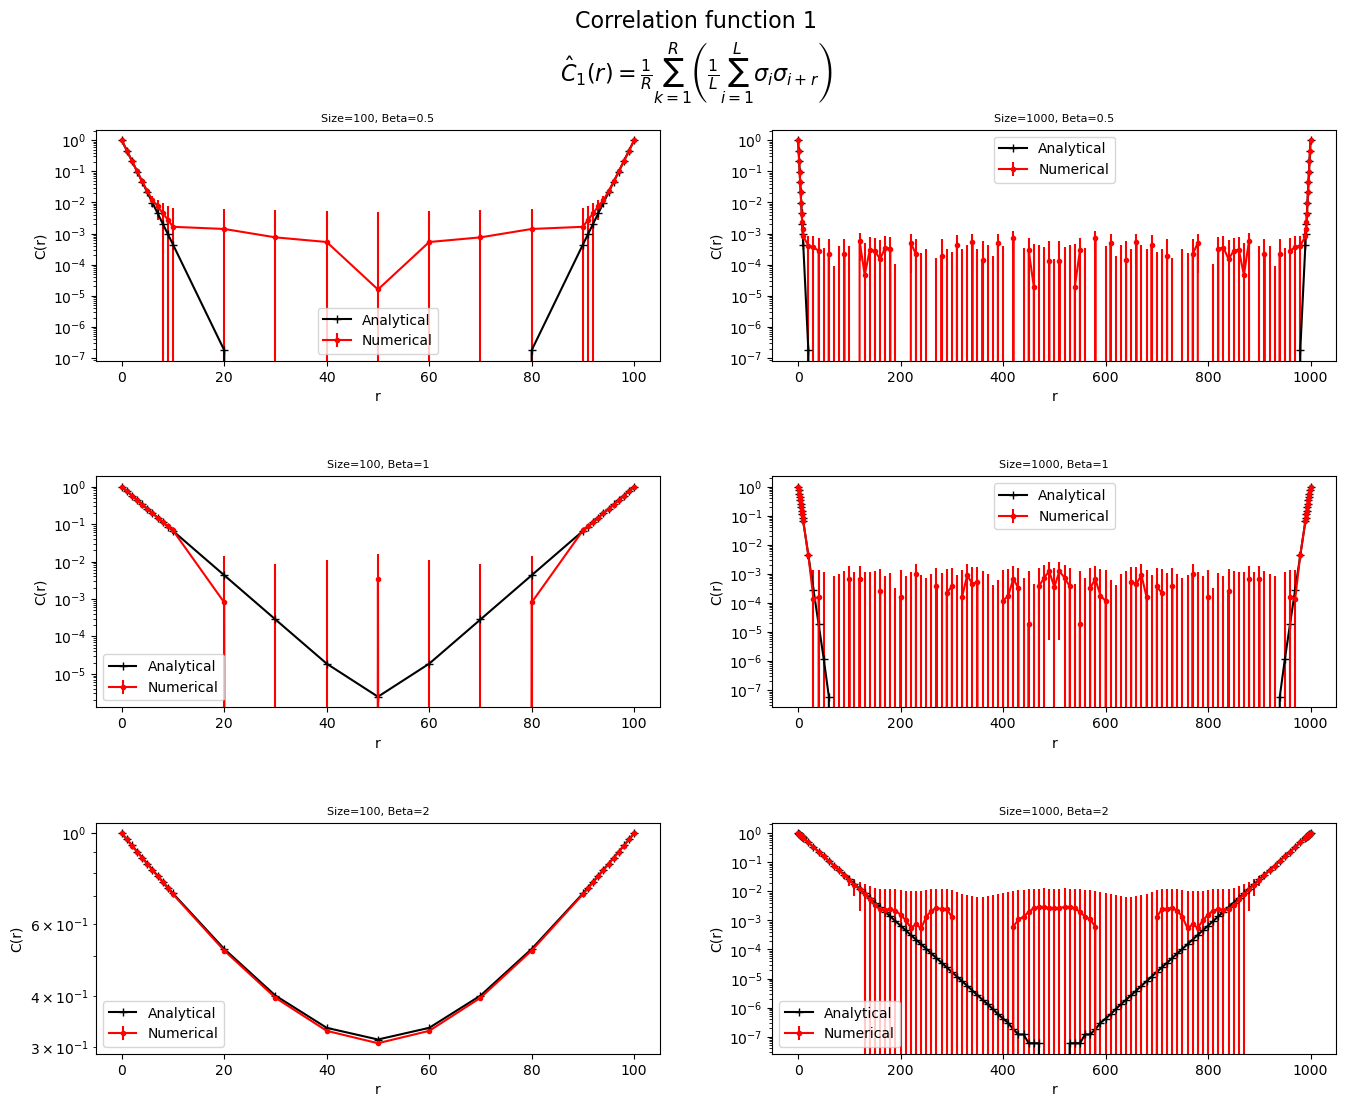

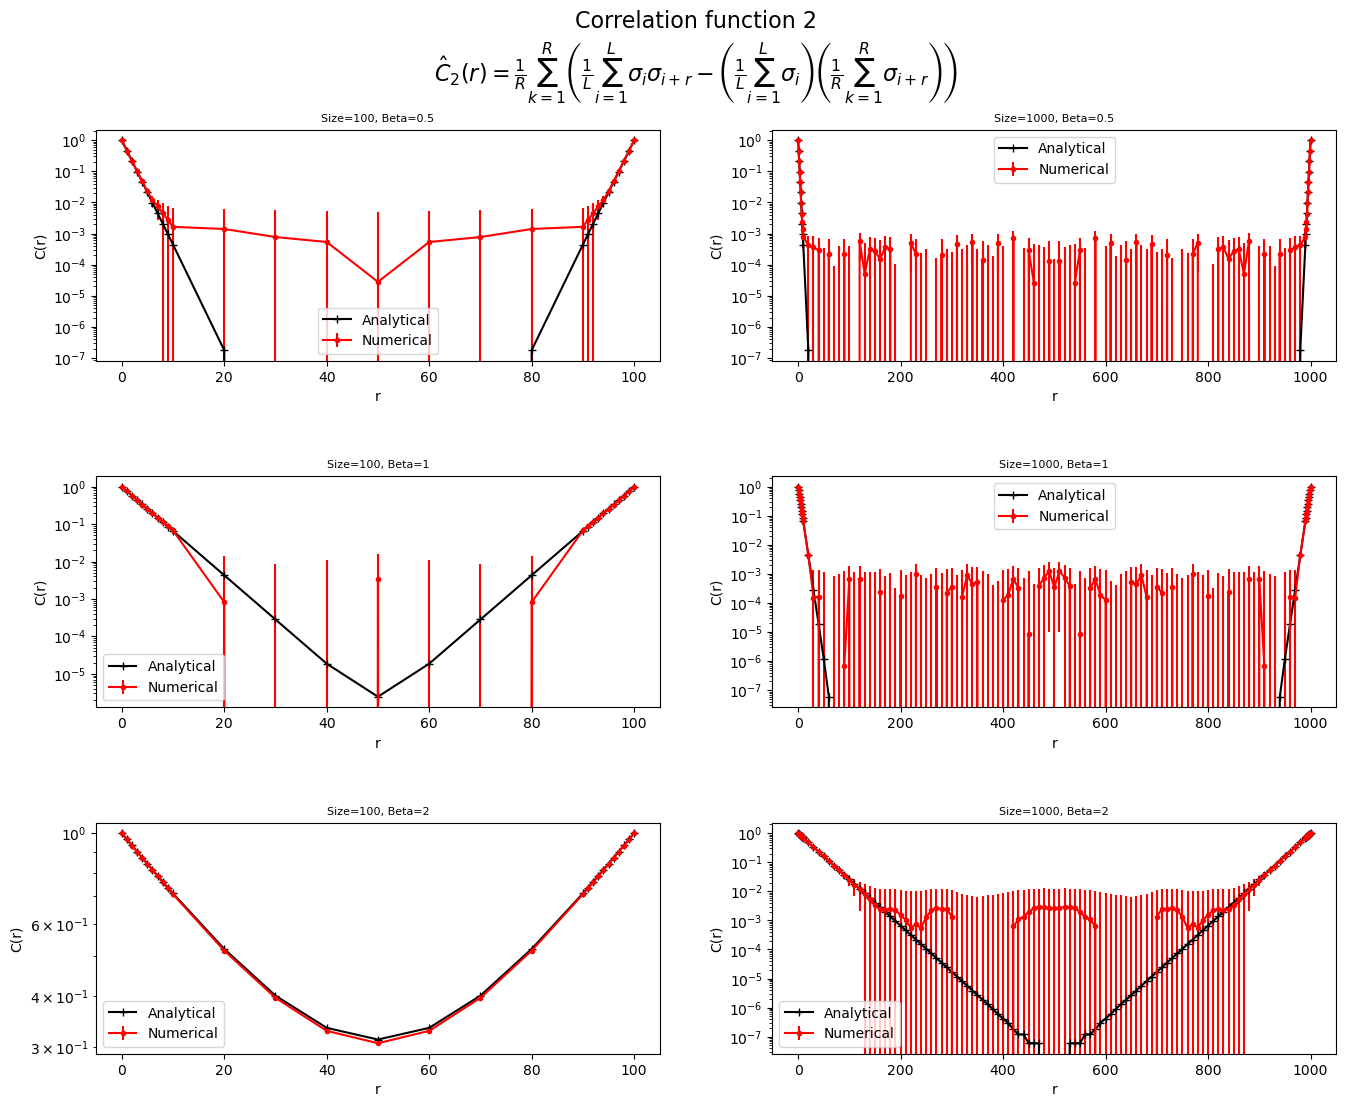

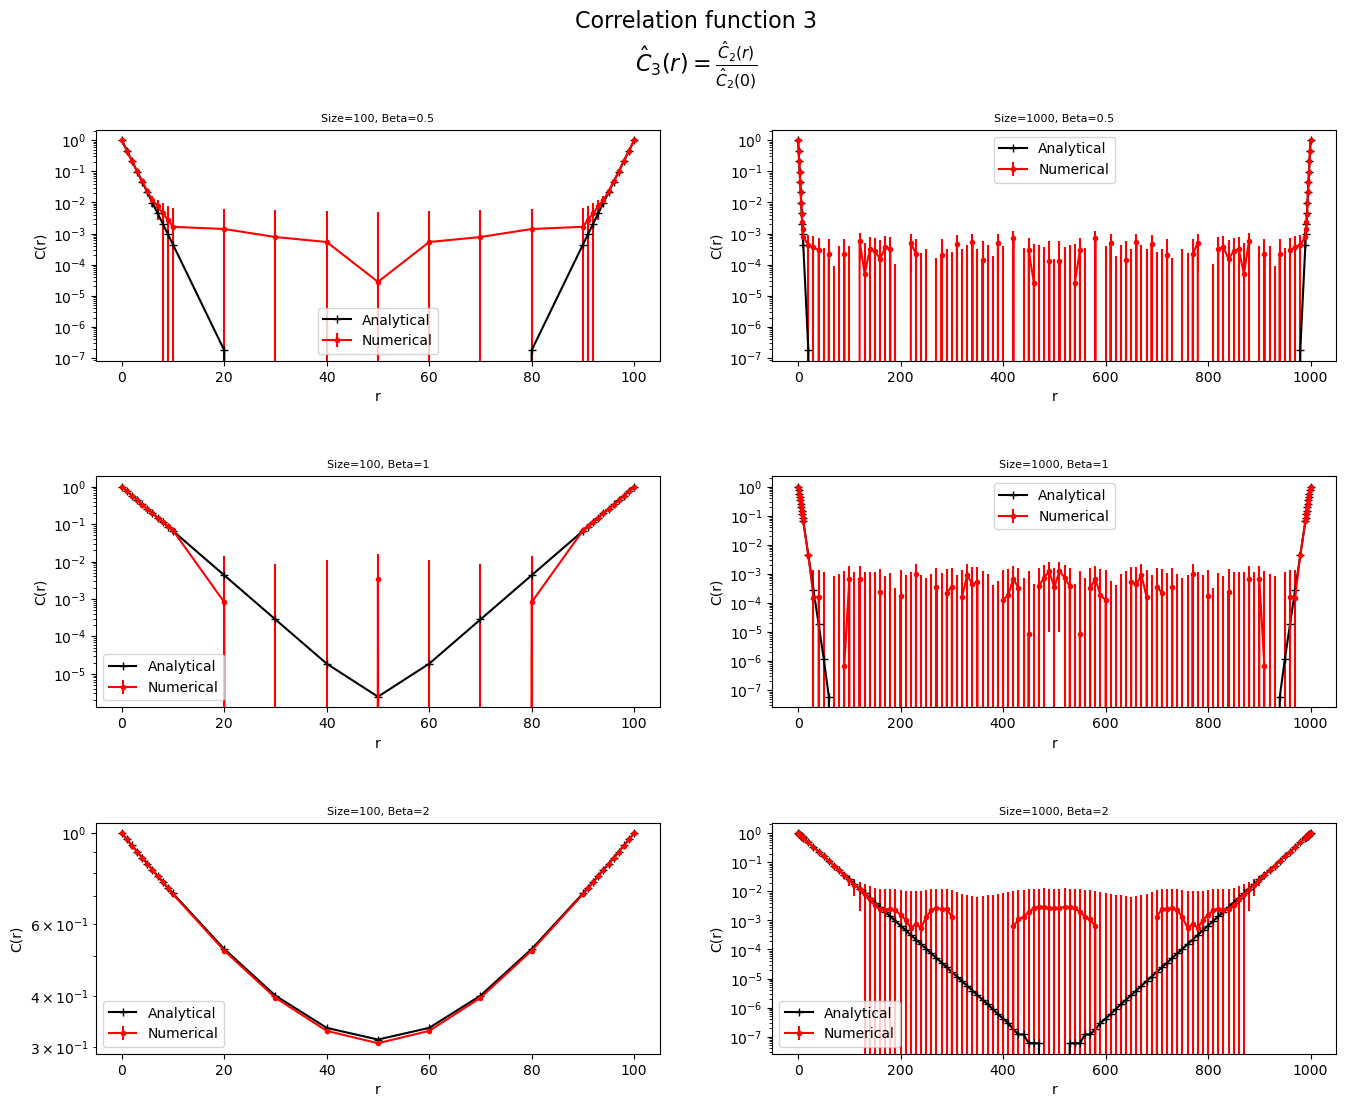

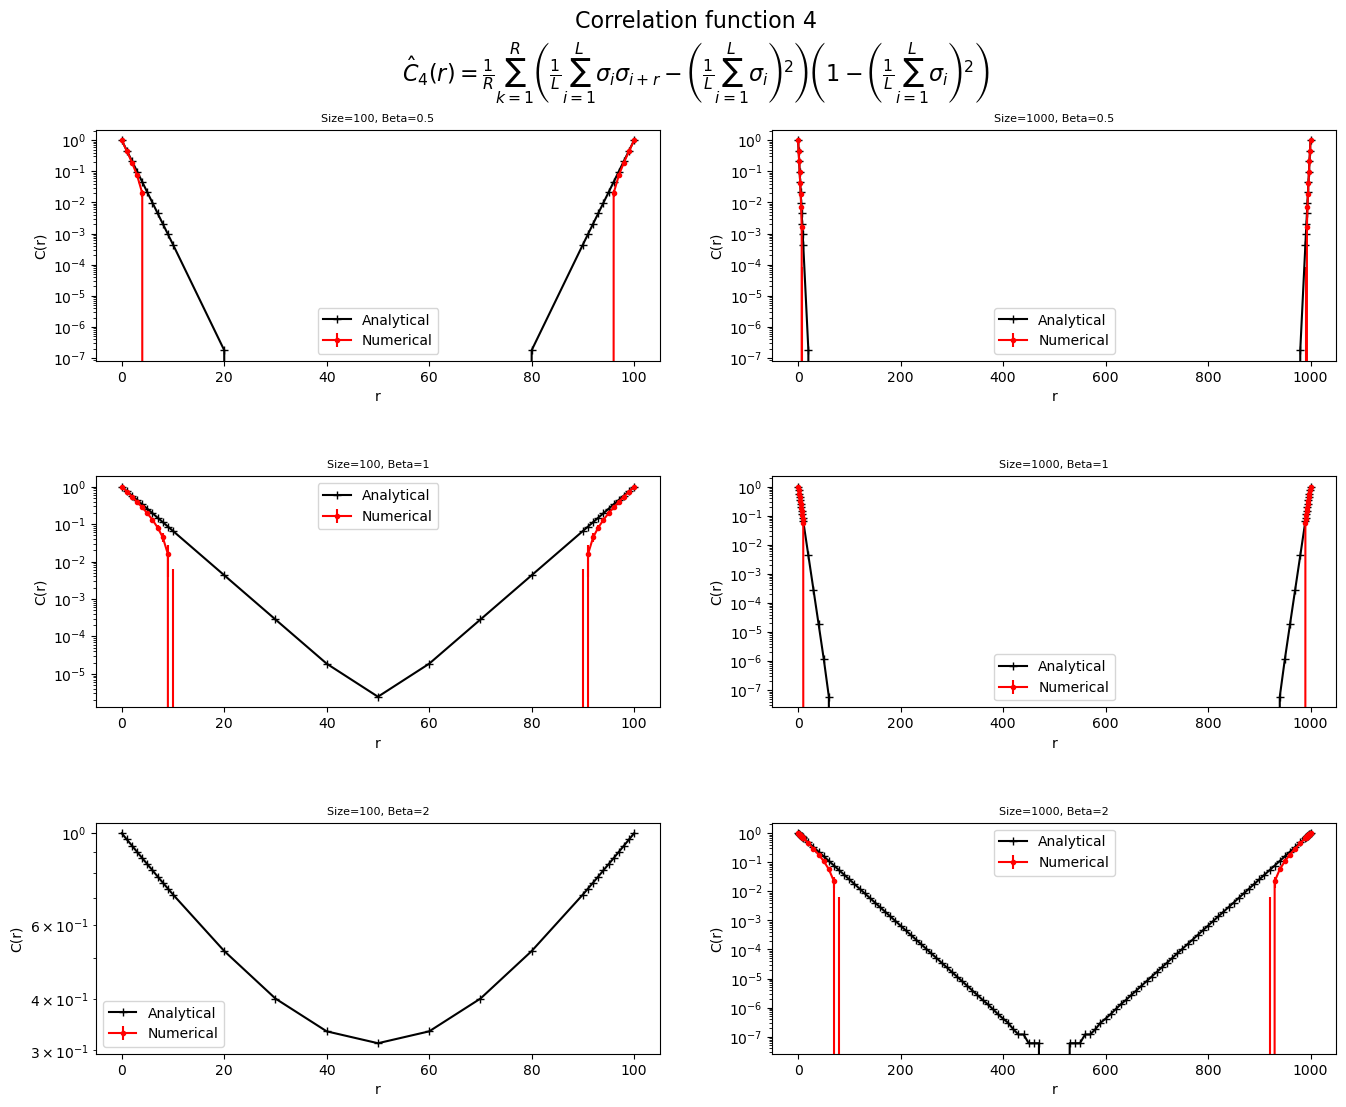

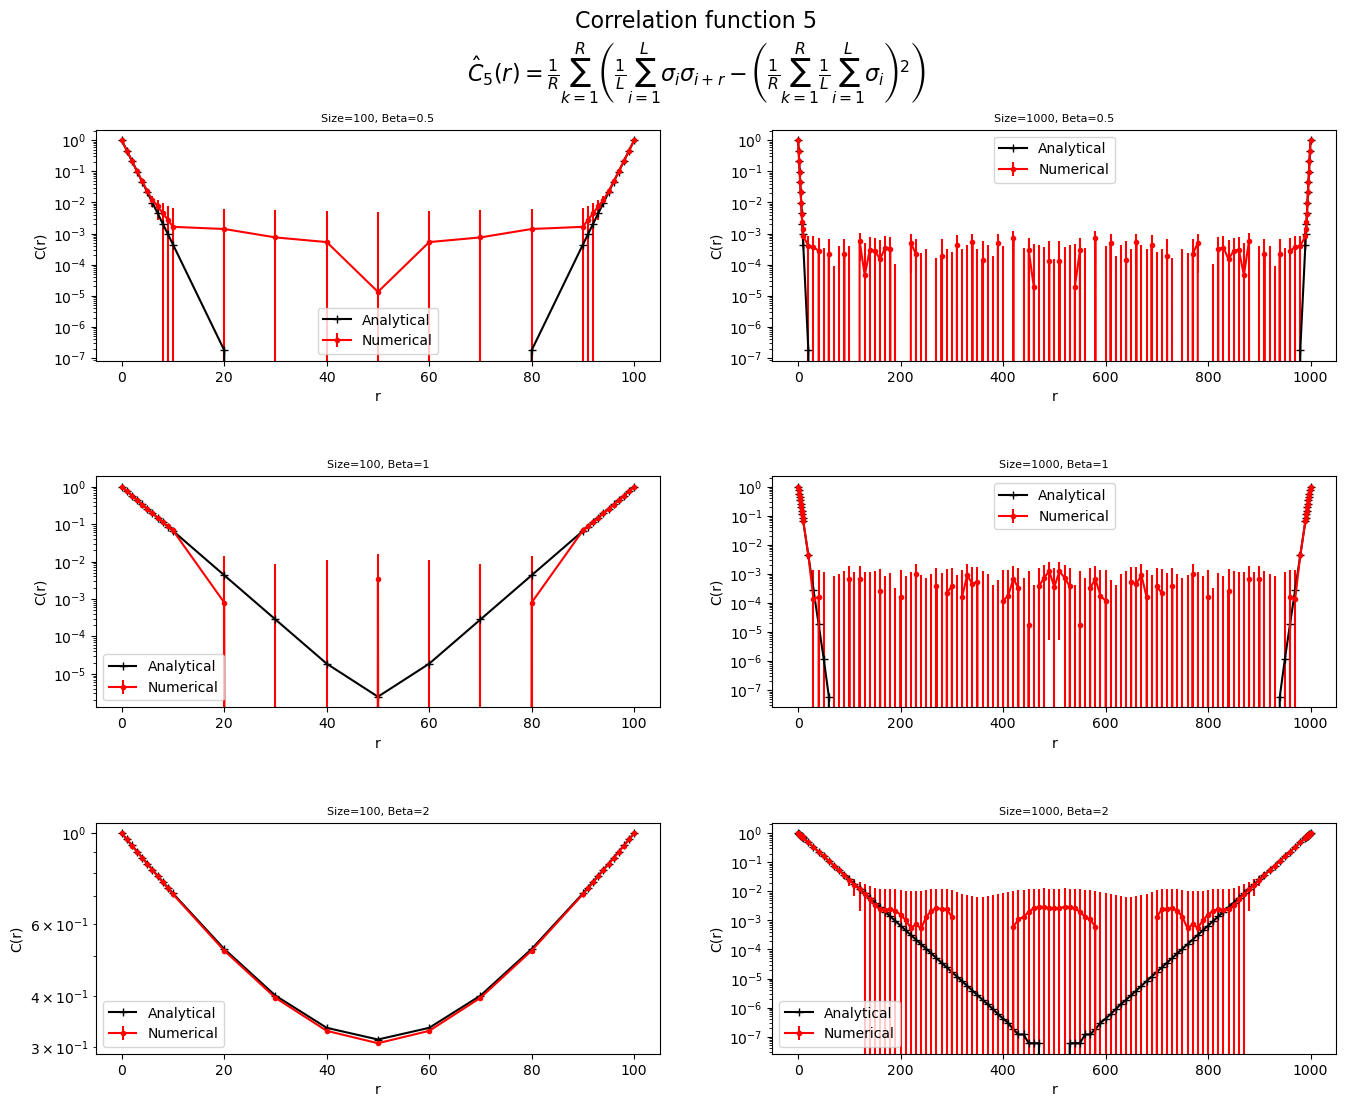

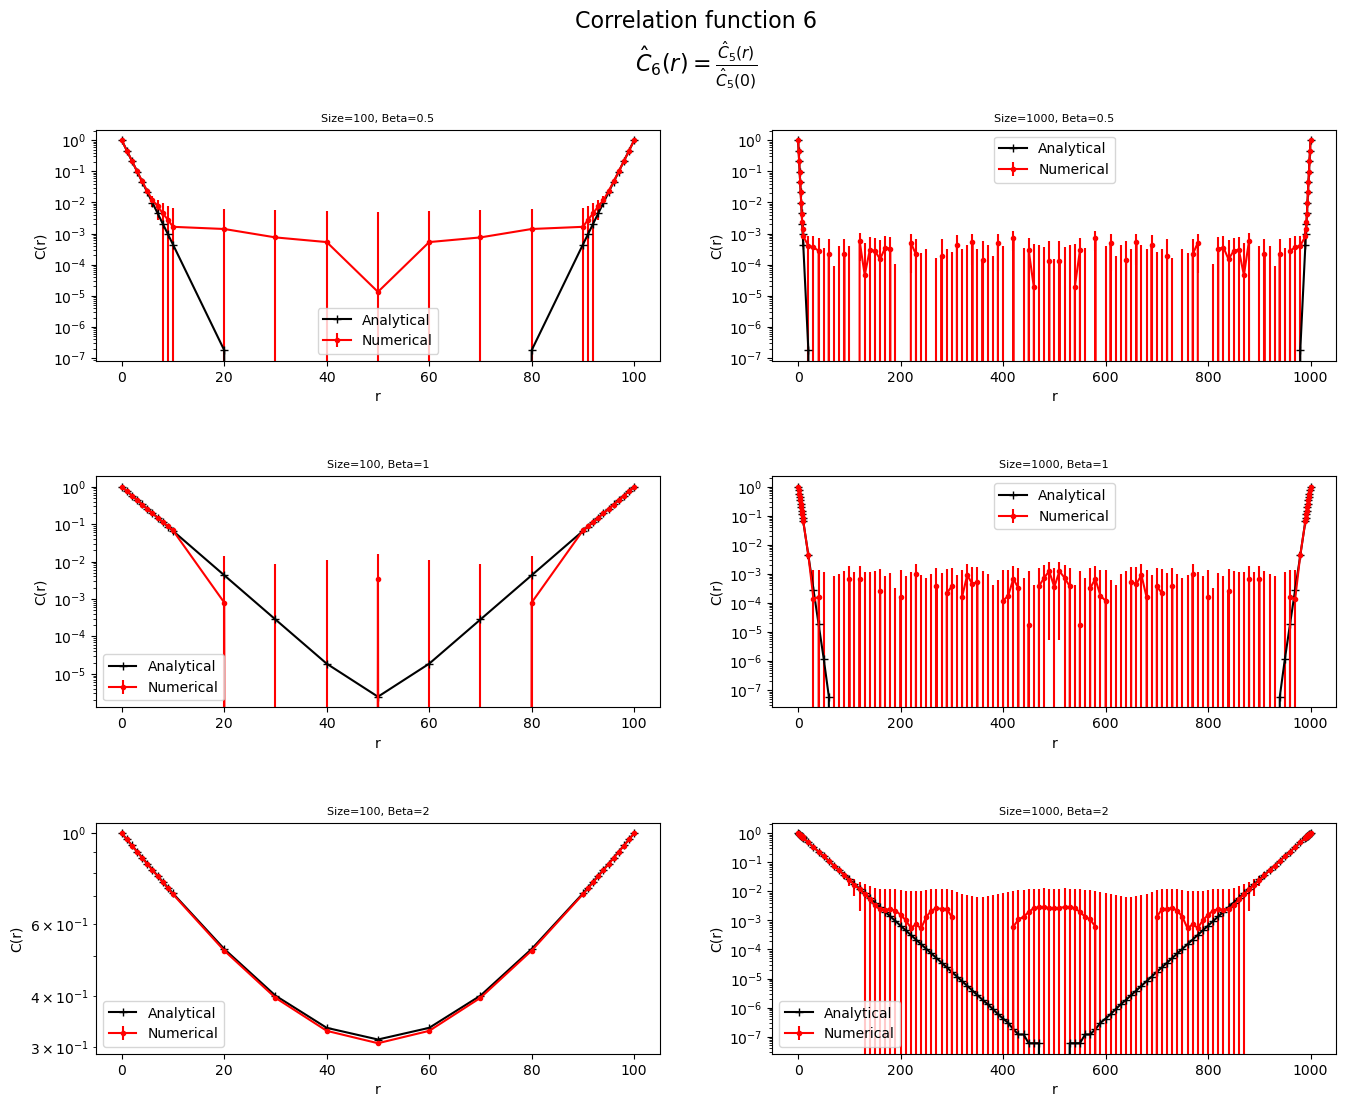

In [8]:
for k, corr_function in enumerate(corr_functions):
    equation = equations.get(corr_function.__name__, 'Equation not defined')
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 4), gridspec_kw={'hspace': 0.5})
    fig.suptitle(f'Correlation function {k+1}\n{equation}', fontsize=16)
    for i, size in enumerate(sizes):
        rs = np.concatenate((np.arange(0, 10, 1), np.arange(10, size - 10, 10), np.arange(size - 10, size + 1, 1)))
        for j, beta in enumerate(betas):
            cr = corrs[k][i][j]
            ax = axes[j, i]
            
            ax.errorbar(rs, cr, yerr=errors[i][j], label='Numerical', marker='.', color='red')
            ax.plot(rs, corrs_an[i][j], label='Analytical', marker='+', color='black')
            
            ax.set_title(f'Size={size}, Beta={beta}', fontsize=8)
            ax.set_xlabel('r')
            ax.set_ylabel('C(r)')
            ax.set_yscale('log')
            ax.legend()
    fig.savefig(f'plots/{corr_function.__name__}.pdf', dpi=1000)